In [116]:
# importing necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lightgbm import LGBMRegressor
import seaborn as sns

In [117]:
# importing dataset
train = pd.read_csv('TRAIN.csv')
test = pd.read_csv('TEST_FINAL.csv')
train.head()

ID  Store_id Store_Type Location_Type Region_Code        Date  \
0  T1000001         1         S1            L3          R1  2018-01-01   
1  T1000002       253         S4            L2          R1  2018-01-01   
2  T1000003       252         S3            L2          R1  2018-01-01   
3  T1000004       251         S2            L3          R1  2018-01-01   
4  T1000005       250         S2            L3          R4  2018-01-01   

   Holiday Discount  #Order     Sales  
0        1      Yes       9   7011.84  
1        1      Yes      60  51789.12  
2        1      Yes      42  36868.20  
3        1      Yes      23  19715.16  
4        1      Yes      62  45614.52

In [118]:
# printing dtypes and null/not null information
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22265 non-null  object
 1   Store_id       22265 non-null  int64 
 

In [119]:
# Converting date column from object to datetime type
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [120]:
# Extracting year, date and day to make new columns as a feature
train['Year'] = train['Date'].dt.year
test['Year'] = test['Date'].dt.year

train['Month'] = train['Date'].dt.month
test['Month'] = test['Date'].dt.month

train['Day'] = train['Date'].dt.day
test['Day'] = test['Date'].dt.day


In [121]:
# Looking at new changes in train data
train.head()

ID  Store_id Store_Type Location_Type Region_Code       Date  \
0  T1000001         1         S1            L3          R1 2018-01-01   
1  T1000002       253         S4            L2          R1 2018-01-01   
2  T1000003       252         S3            L2          R1 2018-01-01   
3  T1000004       251         S2            L3          R1 2018-01-01   
4  T1000005       250         S2            L3          R4 2018-01-01   

   Holiday Discount  #Order     Sales  Year  Month  Day  
0        1      Yes       9   7011.84  2018      1    1  
1        1      Yes      60  51789.12  2018      1    1  
2        1      Yes      42  36868.20  2018      1    1  
3        1      Yes      23  19715.16  2018      1    1  
4        1      Yes      62  45614.52  2018      1    1

In [122]:
# Looking at new changes in test data
test.head()

ID  Store_id Store_Type Location_Type Region_Code       Date  \
0  T1188341       171         S4            L2          R3 2019-06-01   
1  T1188342       172         S1            L1          R1 2019-06-01   
2  T1188343       173         S4            L2          R1 2019-06-01   
3  T1188344       174         S1            L1          R4 2019-06-01   
4  T1188345       170         S1            L1          R2 2019-06-01   

   Holiday Discount  Year  Month  Day  
0        0       No  2019      6    1  
1        0       No  2019      6    1  
2        0       No  2019      6    1  
3        0       No  2019      6    1  
4        0       No  2019      6    1

In [123]:
# Confirming dtype changes and looking at new column dtypes in train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  object        
 3   Location_Type  188340 non-null  object        
 4   Region_Code    188340 non-null  object        
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  object        
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
 10  Year           188340 non-null  int64         
 11  Month          188340 non-null  int64         
 12  Day            188340 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memory usage: 18.7+ MB


In [124]:
# In sales, day of the week, starting of the month and quarter of the year matters a lot
# So I'm creating these new features as it helped in improving my score in the model

train['dayofweek'] = train['Date'].dt.dayofweek
test['dayofweek'] = test['Date'].dt.dayofweek

train['is_month_start'] = train['Date'].dt.is_month_start
test['is_month_start'] = test['Date'].dt.is_month_start

train['is_quarter_start'] = train['Date'].dt.is_quarter_start
test['is_quarter_start'] = test['Date'].dt.is_quarter_start

In [125]:
# Creating one more feature if it's a weekend or not
train['is_weekend'] = train['dayofweek'].apply(lambda x: 1 if x == 5 or x == 6 else 0)
test['is_weekend'] = test['dayofweek'].apply(lambda x: 1 if x == 5 or x == 6 else 0)

In [126]:
# Looking at train data again
train.head()

ID  Store_id Store_Type Location_Type Region_Code       Date  \
0  T1000001         1         S1            L3          R1 2018-01-01   
1  T1000002       253         S4            L2          R1 2018-01-01   
2  T1000003       252         S3            L2          R1 2018-01-01   
3  T1000004       251         S2            L3          R1 2018-01-01   
4  T1000005       250         S2            L3          R4 2018-01-01   

   Holiday Discount  #Order     Sales  Year  Month  Day  dayofweek  \
0        1      Yes       9   7011.84  2018      1    1          0   
1        1      Yes      60  51789.12  2018      1    1          0   
2        1      Yes      42  36868.20  2018      1    1          0   
3        1      Yes      23  19715.16  2018      1    1          0   
4        1      Yes      62  45614.52  2018      1    1          0   

   is_month_start  is_quarter_start  is_weekend  
0            True              True           0  
1            True              True           0  
2            True              True           0  
3            True              True           0  
4            True              True           0

In [127]:
# Dropping unnecessary columns(especially #order which is not in test data)
train = train.drop(['ID','#Order','Date'], axis=1)
test = test.drop(['Date', 'ID'], axis=1)

# EDA

<AxesSubplot:>

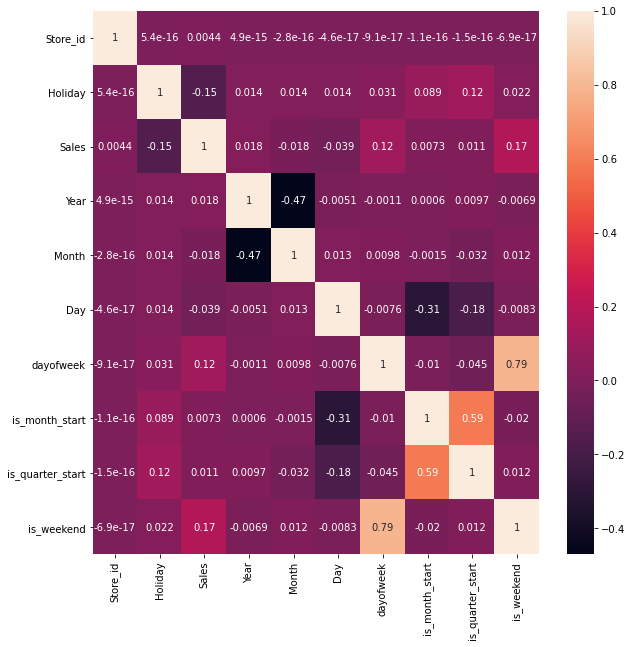

In [128]:
# Plotting heatmap using correlation
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True)

In [129]:
# Checking some figures how each store type has sales 
train.groupby(['Store_Type'])['Sales'].sum().sort_values(ascending=False)

Store_Type
S1    3.343866e+09
S4    2.752946e+09
S3    1.165658e+09
S2    7.955308e+08
Name: Sales, dtype: float64

[[Text(0, 0, 'S3'), Text(1, 0, 'S1'), Text(2, 0, 'S4'), Text(3, 0, 'S2')]]

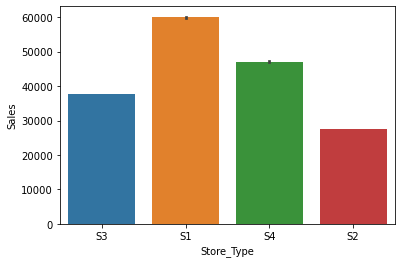

In [130]:
# Now plotting Store type against their sales value

ax = sns.barplot(x='Store_Type', y='Sales', data=train)
ax.set(xticklabels=['S3', 'S1', 'S4', 'S2']) 

[[Text(0, 0, 'S3'), Text(1, 0, 'S1'), Text(2, 0, 'S4'), Text(3, 0, 'S2')]]

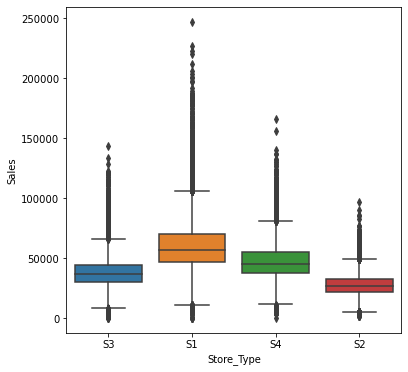

In [131]:
# Now plotting Store type against their sales value using boxplot
plt.figure(figsize=(6,6))
ax = sns.boxplot(x='Store_Type', y='Sales', data=train)
ax.set(xticklabels=['S3', 'S1', 'S4', 'S2'])

In [132]:
# Taking insights of sales based on location type
train.groupby(['Location_Type'])['Sales'].sum().sort_values(ascending=False)

Location_Type
L1    3.529359e+09
L2    2.872964e+09
L3    9.897865e+08
L5    3.509163e+08
L4    3.149745e+08
Name: Sales, dtype: float64

[[Text(0, 0, 'L3'),
  Text(1, 0, 'L1'),
  Text(2, 0, 'L2'),
  Text(3, 0, 'L5'),
  Text(4, 0, 'L4')]]

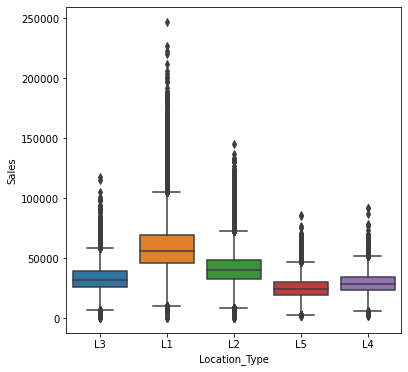

In [133]:
# Sales according to the location type
plt.figure(figsize=(6,6))
ax = sns.boxplot(x='Location_Type', y='Sales', data=train)
ax.set(xticklabels=['L3', 'L1', 'L2', 'L5', 'L4'])

In [134]:
# Taking insights of sales based on store, location and region
train.groupby(['Store_Type', 'Location_Type', 'Region_Code'])['Sales'].count()

Store_Type  Location_Type  Region_Code
S1          L1             R1              8772
                           R2             18060
                           R3             14964
                           R4             11352
            L2             R1               516
                           R2              3096
                           R3              2064
                           R4              1548
            L3             R1              6708
                           R2              6708
                           R3              4644
                           R4               516
            L4             R1              3096
                           R2              1548
                           R3              1548
            L5             R1              2064
                           R2              1548
S2          L1             R1              1032
                           R2              1548
                           R3              1032
 

<AxesSubplot:xlabel='Store_Type', ylabel='Sales'>

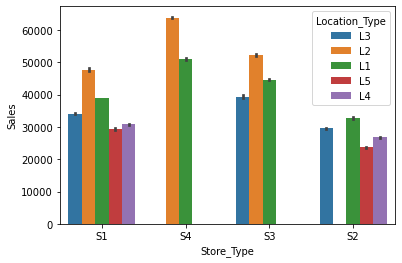

In [135]:
# Plotting it after previous insights by locationwise
sns.barplot(x='Store_Type', y='Sales', hue='Location_Type', data=train)

<AxesSubplot:xlabel='Store_Type', ylabel='Sales'>

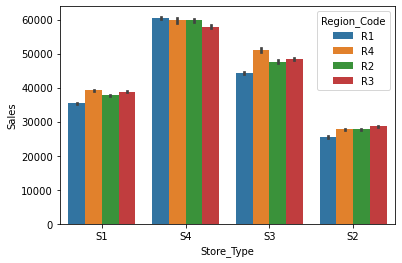

In [136]:
# Plotting it after previous insights by regionwise
sns.barplot(x='Store_Type', y='Sales', hue='Region_Code', data=train)

In [137]:
# sales according to holiday and discount
train.groupby(['Holiday', 'Discount'])['Sales'].sum().sort_values(ascending=False)

Holiday  Discount
0        Yes         3.700618e+09
         No          3.477467e+09
1        Yes         4.654923e+08
         No          4.144234e+08
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Discount', ylabel='Sales'>

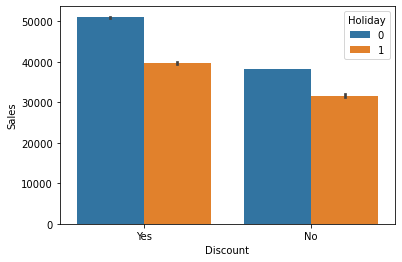

In [138]:
# barplot for previous insights
sns.barplot(x='Discount', y='Sales', hue='Holiday', data=train)

# Handling categorical data

In [139]:
# Mapping month and quarter start from boolean to 1 and 0
train['is_month_start'] = train['is_month_start'].map({True: 1, False: 0})
test['is_month_start'] = test['is_month_start'].map({True: 1, False: 0})

train['is_quarter_start'] = train['is_quarter_start'].map({True: 1, False: 0})
test['is_quarter_start'] = test['is_quarter_start'].map({True: 1, False: 0})

In [140]:
# filtering all object dtype column to convert them to 1 and 0 using get_dummies
obj_col = train.loc[:, train.dtypes == object]
dummy = pd.get_dummies(obj_col, drop_first=True)
dummy

Store_Type_S2  Store_Type_S3  Store_Type_S4  Location_Type_L2  \
0                   0              0              0                 0   
1                   0              0              1                 1   
2                   0              1              0                 1   
3                   1              0              0                 0   
4                   1              0              0                 0   
...               ...            ...            ...               ...   
188335              1              0              0                 0   
188336              0              0              1                 1   
188337              0              0              0                 0   
188338              0              1              0                 0   
188339              1              0              0                 0   

        Location_Type_L3  Location_Type_L4  Location_Type_L5  Region_Code_R2  \
0                      1                 0                 0               0   
1                      0                 0                 0               0   
2                      0                 0                 0               0   
3                      1                 0                 0               0   
4                      1                 0                 0               0   
...                  ...               ...               ...             ...   
188335                 1                 0                 0               1   
188336                 0                 0                 0               0   
188337                 1                 0                 0               1   
188338                 0                 0                 0               1   
188339                 0                 0                 0               0   

        Region_Code_R3  Region_Code_R4  Discount_Yes  
0                    0               0             1  
1                    0               0             1  
2                    0               0             1  
3                    0               0             1  
4                    0               1             1  
...                ...             ...           ...  
188335               0               0             1  
188336               0               0             0  
188337               0               0             0  
188338               0               0             1  
188339               0               0             0  

[188340 rows x 11 columns]

In [141]:
# doing same for the test data
test_obj_col = test.loc[:, test.dtypes == object]
test_dummy = pd.get_dummies(test_obj_col, drop_first=True)
test_dummy

Store_Type_S2  Store_Type_S3  Store_Type_S4  Location_Type_L2  \
0                  0              0              1                 1   
1                  0              0              0                 0   
2                  0              0              1                 1   
3                  0              0              0                 0   
4                  0              0              0                 0   
...              ...            ...            ...               ...   
22260              1              0              0                 0   
22261              0              0              1                 1   
22262              0              0              0                 0   
22263              0              0              0                 0   
22264              1              0              0                 0   

       Location_Type_L3  Location_Type_L4  Location_Type_L5  Region_Code_R2  \
0                     0                 0                 0               0   
1                     0                 0                 0               0   
2                     0                 0                 0               0   
3                     0                 0                 0               0   
4                     0                 0                 0               1   
...                 ...               ...               ...             ...   
22260                 0                 0                 1               1   
22261                 0                 0                 0               0   
22262                 0                 0                 0               0   
22263                 0                 0                 0               0   
22264                 0                 0                 0               1   

       Region_Code_R3  Region_Code_R4  Discount_Yes  
0                   1               0             0  
1                   0               0             0  
2                   0               0             0  
3                   0               1             0  
4                   0               0             0  
...               ...             ...           ...  
22260               0               0             0  
22261               0               0             0  
22262               1               0             1  
22263               0               1             0  
22264               0               0             0  

[22265 rows x 11 columns]

In [142]:
# adding back the dummy data to train
train = pd.concat([train, dummy], axis=1)
train.head()

Store_id Store_Type Location_Type Region_Code  Holiday Discount     Sales  \
0         1         S1            L3          R1        1      Yes   7011.84   
1       253         S4            L2          R1        1      Yes  51789.12   
2       252         S3            L2          R1        1      Yes  36868.20   
3       251         S2            L3          R1        1      Yes  19715.16   
4       250         S2            L3          R4        1      Yes  45614.52   

   Year  Month  Day  ...  Store_Type_S3  Store_Type_S4  Location_Type_L2  \
0  2018      1    1  ...              0              0                 0   
1  2018      1    1  ...              0              1                 1   
2  2018      1    1  ...              1              0                 1   
3  2018      1    1  ...              0              0                 0   
4  2018      1    1  ...              0              0                 0   

   Location_Type_L3  Location_Type_L4  Location_Type_L5  Region_Code_R2  \
0                 1                 0                 0               0   
1                 0                 0                 0               0   
2                 0                 0                 0               0   
3                 1                 0                 0               0   
4                 1                 0                 0               0   

   Region_Code_R3  Region_Code_R4  Discount_Yes  
0               0               0             1  
1               0               0             1  
2               0               0             1  
3               0               0             1  
4               0               1             1  

[5 rows x 25 columns]

In [143]:
# dropping the original columns after dummy creation and addition to original train data

train = train.drop(list(obj_col.columns), axis=1)
train.head()

Store_id  Holiday     Sales  Year  Month  Day  dayofweek  is_month_start  \
0         1        1   7011.84  2018      1    1          0               1   
1       253        1  51789.12  2018      1    1          0               1   
2       252        1  36868.20  2018      1    1          0               1   
3       251        1  19715.16  2018      1    1          0               1   
4       250        1  45614.52  2018      1    1          0               1   

   is_quarter_start  is_weekend  ...  Store_Type_S3  Store_Type_S4  \
0                 1           0  ...              0              0   
1                 1           0  ...              0              1   
2                 1           0  ...              1              0   
3                 1           0  ...              0              0   
4                 1           0  ...              0              0   

   Location_Type_L2  Location_Type_L3  Location_Type_L4  Location_Type_L5  \
0                 0                 1                 0                 0   
1                 1                 0                 0                 0   
2                 1                 0                 0                 0   
3                 0                 1                 0                 0   
4                 0                 1                 0                 0   

   Region_Code_R2  Region_Code_R3  Region_Code_R4  Discount_Yes  
0               0               0               0             1  
1               0               0               0             1  
2               0               0               0             1  
3               0               0               0             1  
4               0               0               1             1  

[5 rows x 21 columns]

In [144]:
# adding back the dummy data to test

test = pd.concat([test, test_dummy], axis=1)
test.head()

Store_id Store_Type Location_Type Region_Code  Holiday Discount  Year  \
0       171         S4            L2          R3        0       No  2019   
1       172         S1            L1          R1        0       No  2019   
2       173         S4            L2          R1        0       No  2019   
3       174         S1            L1          R4        0       No  2019   
4       170         S1            L1          R2        0       No  2019   

   Month  Day  dayofweek  ...  Store_Type_S3  Store_Type_S4  Location_Type_L2  \
0      6    1          5  ...              0              1                 1   
1      6    1          5  ...              0              0                 0   
2      6    1          5  ...              0              1                 1   
3      6    1          5  ...              0              0                 0   
4      6    1          5  ...              0              0                 0   

   Location_Type_L3  Location_Type_L4  Location_Type_L5  Region_Code_R2  \
0                 0                 0                 0               0   
1                 0                 0                 0               0   
2                 0                 0                 0               0   
3                 0                 0                 0               0   
4                 0                 0                 0               1   

   Region_Code_R3  Region_Code_R4  Discount_Yes  
0               1               0             0  
1               0               0             0  
2               0               0             0  
3               0               1             0  
4               0               0             0  

[5 rows x 24 columns]

In [145]:
# dropping the original columns after dummy creation and addition to original test data

test = test.drop(list(test_obj_col.columns), axis=1)
test.head()

Store_id  Holiday  Year  Month  Day  dayofweek  is_month_start  \
0       171        0  2019      6    1          5               1   
1       172        0  2019      6    1          5               1   
2       173        0  2019      6    1          5               1   
3       174        0  2019      6    1          5               1   
4       170        0  2019      6    1          5               1   

   is_quarter_start  is_weekend  Store_Type_S2  Store_Type_S3  Store_Type_S4  \
0                 0           1              0              0              1   
1                 0           1              0              0              0   
2                 0           1              0              0              1   
3                 0           1              0              0              0   
4                 0           1              0              0              0   

   Location_Type_L2  Location_Type_L3  Location_Type_L4  Location_Type_L5  \
0                 1                 0                 0                 0   
1                 0                 0                 0                 0   
2                 1                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   Region_Code_R2  Region_Code_R3  Region_Code_R4  Discount_Yes  
0               0               1               0             0  
1               0               0               0             0  
2               0               0               0             0  
3               0               0               1             0  
4               1               0               0             0

In [146]:
# Checking the shape for train and test data
train.shape, test.shape

((188340, 21), (22265, 20))

In [147]:
# Checking info for both dataset again
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Store_id          188340 non-null  int64  
 1   Holiday           188340 non-null  int64  
 2   Sales             188340 non-null  float64
 3   Year              188340 non-null  int64  
 4   Month             188340 non-null  int64  
 5   Day               188340 non-null  int64  
 6   dayofweek         188340 non-null  int64  
 7   is_month_start    188340 non-null  int64  
 8   is_quarter_start  188340 non-null  int64  
 9   is_weekend        188340 non-null  int64  
 10  Store_Type_S2     188340 non-null  uint8  
 11  Store_Type_S3     188340 non-null  uint8  
 12  Store_Type_S4     188340 non-null  uint8  
 13  Location_Type_L2  188340 non-null  uint8  
 14  Location_Type_L3  188340 non-null  uint8  
 15  Location_Type_L4  188340 non-null  uint8  
 16  Location_Type_L5  18

# Model creation

In [29]:
# Splitting the data into X and y
X = train.drop('Sales', axis=1)
y = train.Sales

In [148]:
# Splitting the data into X_train, X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Using RandomForestRegressor

In [149]:
rfr = RandomForestRegressor(n_estimators=300, max_depth=50, random_state=200, max_leaf_nodes=60,min_samples_leaf=1,max_samples=0.08)

In [150]:
# Fitting the model before scaling to see the prediction
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_leaf_nodes=60, max_samples=0.08,
                      n_estimators=300, random_state=200)

In [151]:
# Checking root mean square error on X_train
rmse = np.sqrt(mean_squared_error(y_train, rfr.predict(X_train)))
rmse

11246.864501595404

In [34]:
# Checking root mean square on X_test
rmse = np.sqrt(mean_squared_error(y_test, rfr.predict(X_test)))
rmse

11242.14416170677

# Using Statsmodel to check variance distribution

In [152]:
# adding constant before passing Xtrain
X_train_sm = sm.add_constant(X_train)
LR = sm.OLS(y_train, X_train)
LR_model = LR.fit()

In [153]:
# Printing the summary
LR_model.summary()

# Rsquare is pretty good

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                          9.382e+04
Date:                Mon, 20 Sep 2021   Prob (F-statistic):                        0.00
Time:                        13:59:45   Log-Likelihood:                     -1.4247e+06
No. Observations:              131838   AIC:                                  2.849e+06
Df Residuals:                  131818   BIC:                                  2.850e+06
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Store_id            -0.2147      0.320     -0.671      0.502      -0.842       0.412
Holiday          -8995.5763     98.238    -91.569      0.000   -9188.122   -8803.031
Year                17.1432      0.073    233.548      0.000      16.999      17.287
Month             -107.6900      9.687    -11.117      0.000    -126.676     -88.704
Day                -18.8698      3.947     -4.781      0.000     -26.605     -11.135
dayofweek         -309.4785     27.025    -11.452      0.000    -362.447    -256.510
is_month_start    -543.5858    236.134     -2.302      0.021   -1006.404     -80.768
is_quarter_start  3655.3801    382.320      9.561      0.000    2906.039    4404.721
is_weekend        8321.7790    119.636     69.559      0.000    8087.294    8556.264
Store_Type_S2    -4806.5001    115.262    -41.701      0.000   -5032.411   -4580.589
Store_Type_S3     4780.4193    109.952     43.477      0.000    4564.915    4995.924
Store_Type_S4     1.357e+04    112.367    120.752      0.000    1.33e+04    1.38e+04
Location_Type_L2  1.051e+04     98.077    107.114      0.000    1.03e+04    1.07e+04
Location_Type_L3 -4477.6125    103.360    -43.321      0.000   -4680.195   -4275.030
Location_Type_L4 -7758.1997    155.611    -49.856      0.000   -8063.195   -7453.205
Location_Type_L5 -1.014e+04    156.723    -64.668      0.000   -1.04e+04   -9827.841
Region_Code_R2    -637.9486     88.845     -7.180      0.000    -812.084    -463.813
Region_Code_R3    -937.0567     94.338     -9.933      0.000   -1121.957    -752.156
Region_Code_R4   -1056.6113    113.957     -9.272      0.000   -1279.964    -833.258
Discount_Yes      1.205e+04     66.378    181.592      0.000    1.19e+04    1.22e+04
==============================================================================
Omnibus:                    42737.369   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           340727.652
Skew:                           1.341   Prob(JB):                         0.00
Kurtosis:                      10.405   Cond. No.                     2.54e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
# Checking VIF score so that if any feature score is > 5, we can drop it to improve our model(except constant)
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF',ascending=False)

Features          VIF
0              const  25275120.93
6          dayofweek         2.70
9         is_weekend         2.69
12     Store_Type_S4         2.16
13  Location_Type_L2         1.70
7     is_month_start         1.65
10     Store_Type_S2         1.60
8   is_quarter_start         1.57
16  Location_Type_L5         1.55
17    Region_Code_R2         1.50
18    Region_Code_R3         1.48
19    Region_Code_R4         1.42
14  Location_Type_L3         1.33
4              Month         1.28
11     Store_Type_S3         1.28
3               Year         1.28
15  Location_Type_L4         1.21
5                Day         1.11
1           Store_id         1.05
2            Holiday         1.02
20      Discount_Yes         1.01

In [155]:
# Choosing high range columns for scaling
col_scale=X_train.loc[:, X_train.dtypes != 'uint8'].drop(['Holiday', 'is_month_start', 'is_quarter_start', 'is_weekend'], axis=1)

In [42]:
# checking the columns after defining it
col_scale.columns

Index(['Store_id', 'Year', 'Month', 'Day', 'dayofweek'], dtype='object')

In [156]:
# Fit and transform on col_scale dataframe
scaler = StandardScaler()
scaled = scaler.fit_transform(col_scale)
scaled

array([[-0.92009269, -0.64332961, -0.73490851, -1.33023328,  1.50306812],
       [ 0.55145133, -0.64332961,  0.73710584, -0.53384441,  1.00277653],
       [ 1.32994558,  1.55441315, -0.44050564, -1.33023328,  0.00219336],
       ...,
       [ 1.00715528, -0.64332961,  0.73710584, -1.67154279, -0.49809822],
       [ 0.50398216, -0.64332961,  0.1483001 , -1.44400311,  1.50306812],
       [ 0.68436498, -0.64332961, -0.44050564,  0.03500478, -1.49868139]])

In [158]:
# replacing with original column and their values
X_train.loc[:, list(col_scale.columns)] = scaled

In [41]:
# Checking X_train after scaling
X_train.head()

Store_id  Holiday      Year     Month       Day  dayofweek  \
22964  -0.920093        0 -0.643330 -0.734909 -1.330233   1.503068   
81316   0.551451        0 -0.643330  0.737106 -0.533844   1.002777   
167174  1.329946        0  1.554413 -0.440506 -1.330233   0.002193   
162541 -0.274512        0  1.554413 -0.734909  0.717624   0.502485   
69960  -0.958068        0 -0.643330  0.442703 -0.533844  -0.498098   

        is_month_start  is_quarter_start  is_weekend  Store_Type_S2  \
22964                0                 0           1              0   
81316                0                 0           1              0   
167174               0                 0           0              0   
162541               0                 0           0              0   
69960                0                 0           0              0   

        Store_Type_S3  Store_Type_S4  Location_Type_L2  Location_Type_L3  \
22964               0              0                 0                 0   
81316               0              0                 0                 0   
167174              0              0                 0                 0   
162541              0              0                 0                 1   
69960               0              1                 1                 0   

        Location_Type_L4  Location_Type_L5  Region_Code_R2  Region_Code_R3  \
22964                  0                 0               0               0   
81316                  0                 0               0               0   
167174                 1                 0               0               0   
162541                 0                 0               1               0   
69960                  0                 0               0               0   

        Region_Code_R4  Discount_Yes  
22964                1             1  
81316                1             1  
167174               0             1  
162541               0             0  
69960                0             0

In [159]:
# preparing high scale column for test dataset
col_scale_test =X_test.loc[:, X_train.dtypes != 'uint8'].drop(['Holiday', 'is_month_start', 'is_quarter_start', 'is_weekend'], axis=1)

In [160]:
# replacing with scaled value in original test dataset 
scaled_X_test = scaler.transform(col_scale_test)
X_test.loc[:,list(col_scale_test.columns)] = scaled_X_test

/home/rahul/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [161]:
# Checking test data
X_test.head()

Store_id  Holiday      Year     Month       Day  dayofweek  \
60213  -1.670105        0 -0.643330  0.148300 -0.192535   0.002193   
167058  1.643242        0  1.554413 -0.440506 -1.444003  -0.498098   
120401 -0.511858        0 -0.643330  1.620314  1.172703  -1.498681   
151218  1.728687        1  1.554413 -1.029311  0.376314  -0.998390   
45385   1.083106        0 -0.643330 -0.146103 -1.216463   1.002777   

        is_month_start  is_quarter_start  is_weekend  Store_Type_S2  \
60213                0                 0           0              0   
167058               0                 0           0              0   
120401               0                 0           0              0   
151218               0                 0           0              1   
45385                0                 0           1              1   

        Store_Type_S3  Store_Type_S4  Location_Type_L2  Location_Type_L3  \
60213               1              0                 0                 0   
167058              1              0                 0                 1   
120401              1              0                 0                 0   
151218              0              0                 0                 0   
45385               0              0                 0                 1   

        Location_Type_L4  Location_Type_L5  Region_Code_R2  Region_Code_R3  \
60213                  0                 0               0               1   
167058                 0                 0               0               0   
120401                 0                 0               0               0   
151218                 0                 0               1               0   
45385                  0                 0               0               0   

        Region_Code_R4  Discount_Yes  
60213                0             1  
167058               0             0  
120401               0             1  
151218               0             0  
45385                1             1

In [162]:
# Defining RandomForest again to see any difference
rfr = RandomForestRegressor(n_estimators=300, max_depth=50, random_state=200, max_leaf_nodes=60,min_samples_leaf=1,max_samples=0.08)

In [163]:
# fit
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_leaf_nodes=60, max_samples=0.08,
                      n_estimators=300, random_state=200)

In [164]:
rmse = np.sqrt(mean_squared_error(y_train, rfr.predict(X_train)))
rmse

11246.682808598835

In [165]:
rmse = np.sqrt(mean_squared_error(y_test, rfr.predict(X_test)))
rmse

11241.747805684925

<h3>Output is still same after scaling. I did this just in case you 
would like to see what scaling does. It is actually to process the data easily 
without getting stuck in local minima</h3>

# Using LightGBM

In [166]:
lgbm = LGBMRegressor(colsample_bytree= 0.66, learning_rate= 0.045, max_depth= 10, max_features= 93, 
                         min_impurity_decrease= 0, min_impurity_split= 1e-07, min_samples_leaf= 1, min_data_in_leaf=2,verbose=-1,
                         min_samples_split= 95, n_estimators= 150, num_leaves= 15, reg_alpha= 1, reg_lambda= 1, 
                         subsample= 0.4,random_state=1,metric='mae',max_iter=4)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: max_iter
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_impurity_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


LGBMRegressor(colsample_bytree=0.66, learning_rate=0.045, max_depth=10,
              max_features=93, max_iter=4, metric='mae', min_data_in_leaf=2,
              min_impurity_decrease=0, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=95, n_estimators=150,
              num_leaves=15, random_state=1, reg_alpha=1, reg_lambda=1,
              subsample=0.4, verbose=-1)

In [167]:
rmse = np.sqrt(mean_squared_error(y_train, lgbm.predict(X_train)))
rmse

9908.707708014477

In [168]:
rmse = np.sqrt(mean_squared_error(y_test, lgbm.predict(X_test)))
rmse

9919.58136595596

<h3>That's here how I did not use lightgdm for the jobathon and my score did not improve.
    It did not struck to me at that time.</h3>

# Using xgboost

In [169]:
boost = xg.XGBRegressor(booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=5,
             n_estimators=110, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
boost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=110, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [170]:
rmse = np.sqrt(mean_squared_error(y_train, boost.predict(X_train)))
rmse

9724.844576502697

In [171]:
rmse = np.sqrt(mean_squared_error(y_test, boost.predict(X_test)))
rmse

9733.396428183136

<h3>It's funny. Here xgboost looks good but at the time of submission score, it's score was always worst.</h3>

# Final submission

In [172]:
# Scaling final test data
test.head()

Store_id  Holiday  Year  Month  Day  dayofweek  is_month_start  \
0       171        0  2019      6    1          5               1   
1       172        0  2019      6    1          5               1   
2       173        0  2019      6    1          5               1   
3       174        0  2019      6    1          5               1   
4       170        0  2019      6    1          5               1   

   is_quarter_start  is_weekend  Store_Type_S2  Store_Type_S3  Store_Type_S4  \
0                 0           1              0              0              1   
1                 0           1              0              0              0   
2                 0           1              0              0              1   
3                 0           1              0              0              0   
4                 0           1              0              0              0   

   Location_Type_L2  Location_Type_L3  Location_Type_L4  Location_Type_L5  \
0                 1                 0                 0                 0   
1                 0                 0                 0                 0   
2                 1                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   Region_Code_R2  Region_Code_R3  Region_Code_R4  Discount_Yes  
0               0               1               0             0  
1               0               0               0             0  
2               0               0               0             0  
3               0               0               1             0  
4               1               0               0             0

In [173]:
# Choosing same column of train to scale
test_col_scale=test.loc[:, test.dtypes != 'uint8'].drop(['Holiday', 'is_month_start', 'is_quarter_start', 'is_weekend'], axis=1)

In [174]:
# only transform it
final_test = scaler.transform(test_col_scale)
test[list(test_col_scale.columns)] = final_test

In [175]:
# looking at it after transform
test.head()

Store_id  Holiday      Year   Month       Day  dayofweek  is_month_start  \
0 -0.113117        0  1.554413  0.1483 -1.671543   1.002777               1   
1 -0.103623        0  1.554413  0.1483 -1.671543   1.002777               1   
2 -0.094129        0  1.554413  0.1483 -1.671543   1.002777               1   
3 -0.084635        0  1.554413  0.1483 -1.671543   1.002777               1   
4 -0.122611        0  1.554413  0.1483 -1.671543   1.002777               1   

   is_quarter_start  is_weekend  Store_Type_S2  Store_Type_S3  Store_Type_S4  \
0                 0           1              0              0              1   
1                 0           1              0              0              0   
2                 0           1              0              0              1   
3                 0           1              0              0              0   
4                 0           1              0              0              0   

   Location_Type_L2  Location_Type_L3  Location_Type_L4  Location_Type_L5  \
0                 1                 0                 0                 0   
1                 0                 0                 0                 0   
2                 1                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   Region_Code_R2  Region_Code_R3  Region_Code_R4  Discount_Yes  
0               0               1               0             0  
1               0               0               0             0  
2               0               0               0             0  
3               0               0               1             0  
4               1               0               0             0

In [177]:
# final prediction
final_test_pred = lgbm.predict(test)

In [178]:
# importing test_final data to extract id
test_file = pd.read_csv('TEST_FINAL.csv')
id = test_file.ID
id

0        T1188341
1        T1188342
2        T1188343
3        T1188344
4        T1188345
           ...   
22260    T1210601
22261    T1210602
22262    T1210603
22263    T1210604
22264    T1210605
Name: ID, Length: 22265, dtype: object

In [179]:
# creation of submission dataframe
my_sub = pd.DataFrame({'ID': id, 'Sales': final_test_pred})
my_sub

ID         Sales
0      T1188341  77580.597036
1      T1188342  48166.301840
2      T1188343  85466.012017
3      T1188344  48166.301840
4      T1188345  48166.301840
...         ...           ...
22260  T1210601  21444.225126
22261  T1210602  59996.289372
22262  T1210603  46089.693028
22263  T1210604  35577.918131
22264  T1210605  30480.047100

[22265 rows x 2 columns]

In [212]:
# Converting to csv
my_sub.to_csv('finalboost8.csv', index=False)

# If You enjoyed this simple explanation of this regression sales problem of jobathon, please upvote it and comment your views. Thank you guys...........!!!!!!!!